In [1]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
from pprint import pprint
import lsst.afw.image as afwImage
from lsst.skymap import Index2D
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

Confirm that local packages are being used, tested with `pipe_tasks` and `drp_tasks`. Need to check this at least until these package versions are in the main stack.

In [6]:
import lsst.pipe.tasks
import lsst.drp.tasks
print(lsst.pipe.tasks.__file__)
print(lsst.drp.tasks.__file__)

/home/m/mgorsuch/rubin-user/repos/pipe_tasks/python/lsst/pipe/tasks/__init__.py
/home/m/mgorsuch/rubin-user/repos/drp_tasks/python/lsst/drp/tasks/__init__.py


In [9]:
# collection = 'u/mgorsuch/make_direct_warp/20240313T003812Z' # for the patch 37 collection, with two visits.
collection = 'u/mgorsuch/make_direct_warp_61/20240314T194854Z' # for the patch 61 collection, with 8 detected warps.
# collection = 'u/mgorsuch/make_direct_warp_61/20240326T202732Z' # to test new code

Check which dataset types are registered in the collection.

In [23]:
for datasetType in registry.queryDatasetTypes():
    if registry.queryDatasets(datasetType, collections=collection).any(execute=False, exact=False):
        print(datasetType)

DatasetType('packages', {}, Packages)
DatasetType('deepCoadd_directWarp', {band, instrument, skymap, physical_filter, tract, patch, visit}, ExposureF)
DatasetType('makeDirectWarp_config', {}, Config)
DatasetType('deepCoaddCell', {band, skymap, tract, patch}, MultipleCellCoadd)
DatasetType('deepCoadd_directWarp_maskedFraction', {band, instrument, skymap, physical_filter, tract, patch, visit}, MaskedImageF)
DatasetType('deepCoadd_directWarp_noise0', {band, instrument, skymap, physical_filter, tract, patch, visit}, MaskedImageF)
DatasetType('deepCoadd_directWarp_noise1', {band, instrument, skymap, physical_filter, tract, patch, visit}, MaskedImageF)
DatasetType('makeDirectWarp_metadata', {band, instrument, skymap, physical_filter, tract, patch, visit}, TaskMetadata)
DatasetType('makeDirectWarp_log', {band, instrument, skymap, physical_filter, tract, patch, visit}, ButlerLogRecords)
DatasetType('assembleCellCoadd_config', {}, Config)
DatasetType('assembleCellCoadd_metadata', {band, skymap,

In [43]:
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC'):
    print(ref.dataId)

{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61, visit: 1242, band: 'i', physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61, visit: 1242, band: 'i', physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61, visit: 1242, band: 'i', physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61, visit: 1242, band: 'i', physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61, visit: 1242, band: 'i', physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61, visit: 1242, band: 'i', physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61, visit: 30490, band: 'i', physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61, visit: 30490, band: 'i', physical_filter: 'HSC-I'}
{instr

In [3]:
for ref in butler.registry.queryDatasets('deepCoaddCell', physical_filter='HSC-I', collections=collection, instrument='HSC'):
    print(ref.dataId.mapping)

{band: 'i', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61}


for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC'):
    print(ref.dataId.mapping)

In [10]:
warp1 = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = 61,
                   visit = 19684)

In [11]:
warp_methods = [m for m in dir(warp1) if not m.startswith('_')]
print(warp_methods)

['Factory', 'apCorrMap', 'clone', 'containsSkyCoords', 'convertD', 'convertF', 'convex_polygon', 'detector', 'dtype', 'filter', 'getBBox', 'getConvexPolygon', 'getCutout', 'getDetector', 'getDimensions', 'getFilter', 'getHeight', 'getImage', 'getInfo', 'getMask', 'getMaskedImage', 'getMetadata', 'getPhotoCalib', 'getPsf', 'getVariance', 'getWcs', 'getWidth', 'getX0', 'getXY0', 'getY0', 'hasPsf', 'hasWcs', 'height', 'image', 'info', 'mask', 'maskedImage', 'photoCalib', 'psf', 'readFits', 'readFitsWithOptions', 'setApCorrMap', 'setDetector', 'setFilter', 'setImage', 'setInfo', 'setMask', 'setMaskedImage', 'setMetadata', 'setPhotoCalib', 'setPsf', 'setVariance', 'setWcs', 'setXY0', 'subset', 'variance', 'visitInfo', 'wcs', 'width', 'writeFits', 'writeFitsWithOptions', 'x0', 'y0']


### Take a look at the cell coadd structure

In [12]:
coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=61,
                     band='i')

The cells within the produced coadd can be "stitched" together to produce a single coadd structure. Useful for displaying the image of an entire patch formed by combining all cells.

In [24]:
stitch_coadd = coadd.stitch()

Check the number of cells with inputs. For instance, the patch 37 contains 85 cells with inputs, while patch 61 has all 484 cells with inputs (484=22x22 cells in a patch, with this configuration).

In [8]:
cell_num = len(list(coadd.cells.keys()))
print(cell_num)

484


We can see a list of the available cells with their index information:

In [14]:
cell_list = list(coadd.cells.keys())
print(cell_list)

[Index2D(x=0, y=0), Index2D(x=1, y=0), Index2D(x=2, y=0), Index2D(x=3, y=0), Index2D(x=4, y=0), Index2D(x=5, y=0), Index2D(x=6, y=0), Index2D(x=7, y=0), Index2D(x=8, y=0), Index2D(x=9, y=0), Index2D(x=10, y=0), Index2D(x=11, y=0), Index2D(x=12, y=0), Index2D(x=13, y=0), Index2D(x=14, y=0), Index2D(x=15, y=0), Index2D(x=16, y=0), Index2D(x=17, y=0), Index2D(x=18, y=0), Index2D(x=19, y=0), Index2D(x=20, y=0), Index2D(x=21, y=0), Index2D(x=0, y=1), Index2D(x=1, y=1), Index2D(x=2, y=1), Index2D(x=3, y=1), Index2D(x=4, y=1), Index2D(x=5, y=1), Index2D(x=6, y=1), Index2D(x=7, y=1), Index2D(x=8, y=1), Index2D(x=9, y=1), Index2D(x=10, y=1), Index2D(x=11, y=1), Index2D(x=12, y=1), Index2D(x=13, y=1), Index2D(x=14, y=1), Index2D(x=15, y=1), Index2D(x=16, y=1), Index2D(x=17, y=1), Index2D(x=18, y=1), Index2D(x=19, y=1), Index2D(x=20, y=1), Index2D(x=21, y=1), Index2D(x=0, y=2), Index2D(x=1, y=2), Index2D(x=2, y=2), Index2D(x=3, y=2), Index2D(x=4, y=2), Index2D(x=5, y=2), Index2D(x=6, y=2), Index2

See how many inputs go into a specific cell:

In [15]:
inputs_list = []
for cell in cell_list:
    cell_inputs = coadd.cells[cell].inputs
    print(cell, len(cell_inputs))
    inputs_list.append(len(cell_inputs))
inputs_list = np.array(inputs_list)
print(inputs_list)

Index2D(x=0, y=0) 7
Index2D(x=1, y=0) 7
Index2D(x=2, y=0) 7
Index2D(x=3, y=0) 7
Index2D(x=4, y=0) 7
Index2D(x=5, y=0) 7
Index2D(x=6, y=0) 7
Index2D(x=7, y=0) 7
Index2D(x=8, y=0) 7
Index2D(x=9, y=0) 7
Index2D(x=10, y=0) 7
Index2D(x=11, y=0) 7
Index2D(x=12, y=0) 7
Index2D(x=13, y=0) 6
Index2D(x=14, y=0) 6
Index2D(x=15, y=0) 5
Index2D(x=16, y=0) 4
Index2D(x=17, y=0) 4
Index2D(x=18, y=0) 5
Index2D(x=19, y=0) 4
Index2D(x=20, y=0) 4
Index2D(x=21, y=0) 4
Index2D(x=0, y=1) 7
Index2D(x=1, y=1) 7
Index2D(x=2, y=1) 7
Index2D(x=3, y=1) 7
Index2D(x=4, y=1) 7
Index2D(x=5, y=1) 7
Index2D(x=6, y=1) 7
Index2D(x=7, y=1) 7
Index2D(x=8, y=1) 7
Index2D(x=9, y=1) 7
Index2D(x=10, y=1) 7
Index2D(x=11, y=1) 7
Index2D(x=12, y=1) 7
Index2D(x=13, y=1) 6
Index2D(x=14, y=1) 6
Index2D(x=15, y=1) 5
Index2D(x=16, y=1) 4
Index2D(x=17, y=1) 4
Index2D(x=18, y=1) 5
Index2D(x=19, y=1) 4
Index2D(x=20, y=1) 4
Index2D(x=21, y=1) 4
Index2D(x=0, y=2) 7
Index2D(x=1, y=2) 7
Index2D(x=2, y=2) 7
Index2D(x=3, y=2) 7
Index2D(x=4, y=2

## Plotting cell input histogram

(array([  0.,   9.,  21.,  71., 119.,  85.,  80.,  99.,   0.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

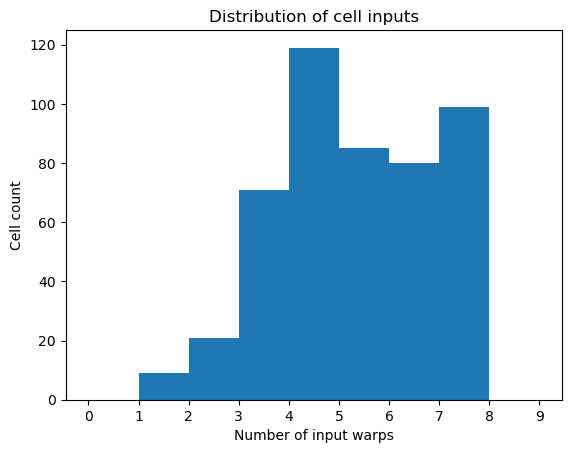

In [16]:
bins = np.arange(0, np.max(inputs_list)+3)
plt.xlabel("Number of input warps")
plt.ylabel("Cell count")
plt.title("Distribution of cell inputs")
plt.xticks(bins)
plt.hist(inputs_list, bins)

## Showing cell images

The backend used for displaying image data will be firefly here, though other options are available. 

Some other points:
- Define both `display1` and `display2` in the same notebook cell each time, to keep the displays updated and avoid loading image data from previous notebook cells.
- Firefly will load another tab within the notebook environment. Keep this tab open, since as far as I know the only way to get this tab back is to reload the notebook environment. Redefining the displays will update the current tab instead of creating a new tab.

In [20]:
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('firefly')

The image data stored in a cell can be called in the following way: 

In [18]:
cell_imMask_out = coadd.cells[Index2D(x=17, y=18)].outer.asMaskedImage()
cell_imMask_in = coadd.cells[Index2D(x=17, y=18)].inner.asMaskedImage()

The inner cell is the boundary of just the single cell, whereas the outer cell contains overlapping image data with neighboring cells. To display the difference between those images, call the below notebook cell:

In [21]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(cell_imMask_out)
display2 = afwDisplay.Display(frame=2)
display2.mtv(cell_imMask_in)

We can also call on the `stitch_coadd` object to display all cells across an entire patch:

In [85]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(stitch_coadd.asMaskedImage())
display2 = afwDisplay.Display(frame=2)
display2.mtv(stitch_coadd.asExposure())

## Investigate NO_DATA

Find the cell that contains a large amount of NO_DATA masked pixels.
- The 2305, 715 coordinate is found using the Firefly display and hovering over the masked pixels. The readout option should be set to FITS Image Pixel. However, the coadd object does not have an origin at 0,0. This offset must be added, and is found using `getMin()` method.

In [35]:
import lsst.geom as geom
print(coadd.grid.index(coadd.inner_bbox.getMin()+(geom.Extent2I(2305, 715))))

Index2D(x=15, y=4)


Find the input warps used in this cell:

In [24]:
cell_no_data = coadd.cells[Index2D(x=15, y=4)]
print(cell_no_data.inputs)

frozenset({ObservationIdentifiers(instrument='HSC', packed=4690, visit=19684, detector=50)})


Using the output above, read in the relevant warp:

In [22]:
# get the above warp with no_data from the butler
warp2 = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract=9813,
                   patch=61,
                   visit = 19684)

#### Compare the warp, stitiched coadd, and cell images

Read in the relevant warp and the cell with NO_DATA masked pixels:

In [11]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(warp2.maskedImage)
display2 = afwDisplay.Display(frame=2)
display2.mtv(coadd.cells[Index2D(x=15, y=4)].inner.asMaskedImage())

Read in the stitched coadd and the cell with NO_DATA masked pixels:

In [10]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(stitch_coadd.asMaskedImage())
display2 = afwDisplay.Display(frame=2)
display2.mtv(coadd.cells[Index2D(x=15, y=4)].inner.asMaskedImage())

### Investigate NO_DATA in normal warping/coaddition process (none cell-based)

In [3]:
collection_warp_no_data = 'u/mgorsuch/make_warp_patch_61/20240320T205831Z'
collection_coadd_no_data = 'u/mgorsuch/coadd_patch_61/20240320T210806Z'

In [21]:
for datasetType in registry.queryDatasetTypes():
    if registry.queryDatasets(datasetType, collections=collection_warp_no_data).any(execute=False, exact=False):
        print(datasetType)

DatasetType('packages', {}, Packages)
DatasetType('deepCoadd_psfMatchedWarp', {band, instrument, skymap, physical_filter, tract, patch, visit}, ExposureF)
DatasetType('deepCoadd_directWarp', {band, instrument, skymap, physical_filter, tract, patch, visit}, ExposureF)
DatasetType('makeWarp_metadata', {band, instrument, skymap, physical_filter, tract, patch, visit}, PropertySet)
DatasetType('makeWarp_config', {}, Config)
DatasetType('makeWarp_log', {band, instrument, skymap, physical_filter, tract, patch, visit}, ButlerLogRecords)


In [22]:
for datasetType in registry.queryDatasetTypes():
    if registry.queryDatasets(datasetType, collections=collection_coadd_no_data).any(execute=False, exact=False):
        print(datasetType)

DatasetType('packages', {}, Packages)
DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF)
DatasetType('deepCoadd_nImage', {band, skymap, tract, patch}, ImageU)
DatasetType('assembleCoadd_metadata', {band, skymap, tract, patch}, PropertySet)
DatasetType('assembleCoadd_config', {}, Config)
DatasetType('deepCoadd_inputMap', {band, skymap, tract, patch}, HealSparseMap)
DatasetType('assembleCoadd_log', {band, skymap, tract, patch}, ButlerLogRecords)


In [23]:
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection_warp_no_data, instrument='HSC'):
    print(ref.dataId)

{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61, visit: 1242, band: 'i', physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61, visit: 1242, band: 'i', physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61, visit: 1242, band: 'i', physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61, visit: 1242, band: 'i', physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61, visit: 1242, band: 'i', physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61, visit: 1242, band: 'i', physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61, visit: 30490, band: 'i', physical_filter: 'HSC-I'}
{instrument: 'HSC', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61, visit: 30490, band: 'i', physical_filter: 'HSC-I'}
{instr

In [24]:
for ref in butler.registry.queryDatasets('deepCoadd', physical_filter='HSC-I', collections=collection_coadd_no_data, instrument='HSC'):
    print(ref.dataId)

{band: 'i', skymap: 'hsc_rings_cells_v1', tract: 9813, patch: 61}


Read in the relevant warp and coadd

In [4]:
warp_no_data = butler.get('deepCoadd_directWarp',
                   collections = collection_warp_no_data,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract=9813,
                   patch=61,
                   visit = 19684)

In [5]:
coadd_no_data = butler.get('deepCoadd',
                   collections = collection_coadd_no_data,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract=9813,
                   patch=61,
                   band = 'i')

In [6]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(warp_no_data.maskedImage)
display2 = afwDisplay.Display(frame=2)
display2.mtv(coadd_no_data.getMaskedImage())

## Play with mask information

### For a single cell

See what masks are being used in a cell

In [21]:
print(cell.inner.mask.getMaskPlaneDict())

{'BAD': 0, 'CR': 3, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INTRP': 2, 'NO_DATA': 8, 'SAT': 1, 'SUSPECT': 7}


If you have the mask plane name, find what value is associated with it

In [40]:
print(cell.inner.mask.getMaskPlane('CR'))

3


Get the number of pixels with a specific mask within a cell

In [25]:
mask_used = 'CR'
print("Mask used: ", mask_used)
mask_bit = cell.inner.mask.getPlaneBitMask(mask_used)
print("Mask bit number: ", mask_bit)
num_bad_pixels = len(np.where(np.bitwise_and(cell.inner.mask.array, mask_bit))[0])
print("Number of masked pixels: ", num_bad_pixels)

Mask used:  CR
Mask bit number:  8
Number of masked pixels:  68


### For a whole patch (22x22 cells)

In [26]:
mask_used = 'CR'
print("Mask used: ", mask_used)
mask_bit = stitch_coadd.mask.getPlaneBitMask(mask_used)
print("Mask bit number: ", mask_bit)
num_bad_pixels = len(np.where(np.bitwise_and(stitch_coadd.mask.array, mask_bit))[0])
print("Number of masked pixels: ", num_bad_pixels)

Mask used:  CR
Mask bit number:  8
Number of masked pixels:  84482


## Plot mask information

There is probably a more efficient way to do this but this is for a first try

Index2D(x=10, y=0)
Index2D(x=16, y=0)
Index2D(x=17, y=0)
Index2D(x=18, y=0)
Index2D(x=19, y=0)
Index2D(x=20, y=0)
Index2D(x=21, y=0)
Index2D(x=0, y=1)
Index2D(x=4, y=2)
Index2D(x=5, y=2)
Index2D(x=10, y=2)
Index2D(x=21, y=2)
Index2D(x=16, y=3)
Index2D(x=17, y=3)
Index2D(x=19, y=3)
Index2D(x=6, y=4)
Index2D(x=7, y=4)
Index2D(x=9, y=4)
Index2D(x=10, y=4)
Index2D(x=15, y=4)
Index2D(x=16, y=4)
Index2D(x=17, y=4)
Index2D(x=19, y=4)
Index2D(x=20, y=4)
Index2D(x=6, y=5)
Index2D(x=7, y=5)
Index2D(x=19, y=6)
Index2D(x=9, y=7)
Index2D(x=13, y=8)
Index2D(x=5, y=9)
Index2D(x=15, y=9)
Index2D(x=17, y=9)
Index2D(x=11, y=10)
Index2D(x=17, y=10)
Index2D(x=4, y=11)
Index2D(x=5, y=11)
Index2D(x=5, y=12)
Index2D(x=6, y=12)
Index2D(x=9, y=12)
Index2D(x=10, y=12)
Index2D(x=13, y=12)
Index2D(x=14, y=12)
Index2D(x=9, y=13)
Index2D(x=6, y=15)
Index2D(x=0, y=16)
Index2D(x=1, y=16)
Index2D(x=15, y=16)
Index2D(x=16, y=16)
Index2D(x=17, y=16)
Index2D(x=19, y=16)
Index2D(x=20, y=16)
Index2D(x=0, y=17)
Index2D(x=1,

Text(0, 0.5, 'Cell count')

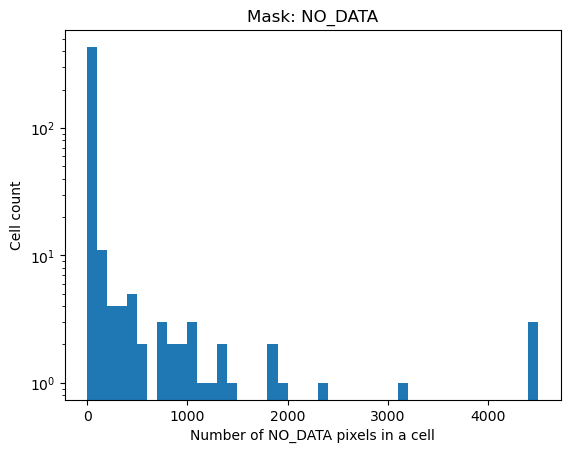

In [44]:
num_mask_pix = []
plot_mask = 'NO_DATA'
# for now assume the bit is the same for each cell, and use the bit from the first cell to avoid calling the bit number 400+ times
# TO-DO check that each cell uses the same bits for each mask
mask_bit = cell.inner.mask.getPlaneBitMask(plot_mask)

for cell_index in cell_list:
    
    cell_mask = coadd.cells[cell_index]
    num_bad_pixels = len(np.where(np.bitwise_and(cell_mask.inner.mask.array, mask_bit))[0])
    if num_bad_pixels>0:
        print(cell_index)
    num_mask_pix.append(num_bad_pixels)
num_mask_pix = np.array(num_mask_pix)
# print(num_mask_pix)

# plot data as a histogram
bins = np.arange(0, np.max(num_mask_pix)+1, 100)
plt.hist(num_mask_pix, bins)
plt.title(f"Mask: {plot_mask}")
plt.xlabel(f"Number of {plot_mask} pixels in a cell")
plt.yscale("log")
plt.ylabel("Cell count")

## Generate 2D histogram of number of cell inputs across patch 61

Generate an array of input data from each cell (this may need some fiddling with getting differing array structures to work together)

In [26]:
stitch_coadd.asExposure().getDimensions()

Extent2I(3400, 3400)

Get the grid structure of the stitched coadd:

In [27]:
print(stitch_coadd.grid)

UniformGrid(cell_size=Extent2I(150, 150), shape=(22, 22), min=Point2I(17850, 14850))


Arrange the number if inputs for each cell into a 2D grid:

In [40]:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

inputs_list = np.empty([22,22])

for cell in cell_list:
    num_cell_inputs = len(coadd.cells[cell].inputs)
    x_index = cell.x
    y_index = cell.y
        
    inputs_list[y_index][x_index] = num_cell_inputs

Plot the 2D grid of cell inputs:

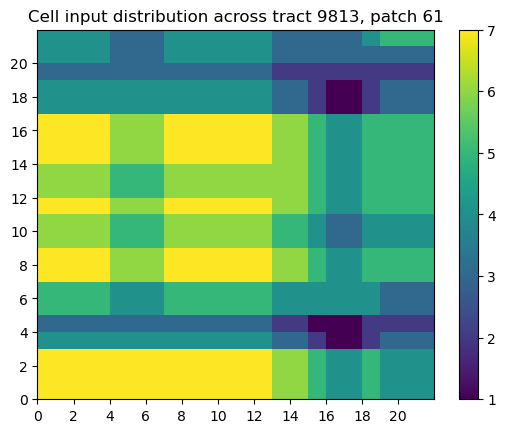

In [47]:
plt.pcolormesh(x_cell_bin, y_cell_bin, inputs_list, shading='auto', vmin=inputs_list.min(), vmax=inputs_list.max(), linewidths=4)
plt.xticks(np.arange(0, 21, 2))
plt.yticks(np.arange(0, 21, 2))
plt.title("Cell input distribution across tract 9813, patch 61")
plt.colorbar()

Brief check that index of cells are lining up as expected

In [14]:
print(len(coadd.cells[Index2D(x=0, y=0)].inputs)) # expect 7
print(len(coadd.cells[Index2D(x=15, y=4)].inputs)) # expect 1
print(len(coadd.cells[Index2D(x=7, y=9)].inputs)) # expect 6

7
1
6


## Display above histogram over the stitched coadd

Maybe not as useful as I had hoped, but still an interesting exercise in manipulating array images.

In [33]:
import lsst.geom as afwGeom

In [30]:
flipped_stitch = np.flip(stitch_coadd.image.getArray(), axis=0)

Many different ways to retrieve the bounding box coordinates:

In [31]:
# coadd pixel coordinates for minimum corner and maximum corner
print(stitch_coadd.bbox)
# split up the four values
print(stitch_coadd.bbox.beginX)
print(stitch_coadd.bbox.beginY)
print(stitch_coadd.bbox.maxX)
print(stitch_coadd.bbox.maxY)
# get each corner
print(stitch_coadd.bbox.getBegin())
print(stitch_coadd.bbox.getMax())

(minimum=(17800, 14800), maximum=(21199, 18199))
17800
14800
21199
18199
(17800, 14800)
(21199, 18199)


Remove the image padding (50 pixels added to each side, actual image should be 3300x3300 pixels:

In [36]:
bbox = afwGeom.Box2I()
bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getBegin()+(geom.Extent2I(50, 50))))
bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getMax()-(geom.Extent2I(50, 50))))
cutout = stitch_coadd.asExposure()[bbox]
print(cutout.getDimensions())

(3300, 3300)


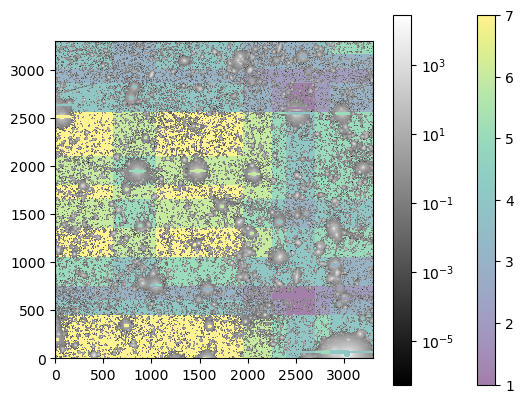

In [41]:
from matplotlib.colors import LogNorm
plt.pcolormesh(x_cell_bin, y_cell_bin, inputs_list, shading='auto', vmin=inputs_list.min(), vmax=inputs_list.max(), alpha=0.5)
# extent = np.min(x), np.max(x), np.min(y), np.max(y)
extent = 0, 3300, 0, 3300
im1 = plt.imshow(np.flip(inputs_list, axis=0), alpha=0.5, extent=extent)
color1 = plt.colorbar(im1)
im2 = plt.imshow(np.flip(cutout.image.getArray(), axis=0), cmap='gray', norm=LogNorm(), extent=extent)
color2 = plt.colorbar(im2)
plt.show()